In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime , timedelta
from scipy.stats import norm

In [2]:
def black_scholes_call(S,K,T,r,sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

In [3]:
symbol = '^NSEI'
ticker = yf.Ticker(symbol)
now = datetime.now().strftime('%Y-%m-%d')
data = ticker.history(start='2024-7-1',end=now).Close
print(data)

Date
2024-07-01 00:00:00+05:30    24141.949219
2024-07-02 00:00:00+05:30    24123.849609
2024-07-03 00:00:00+05:30    24286.500000
2024-07-04 00:00:00+05:30    24302.150391
2024-07-05 00:00:00+05:30    24323.849609
                                 ...     
2025-08-08 00:00:00+05:30    24363.300781
2025-08-11 00:00:00+05:30    24585.050781
2025-08-12 00:00:00+05:30    24487.400391
2025-08-13 00:00:00+05:30    24619.349609
2025-08-14 00:00:00+05:30    24631.300781
Name: Close, Length: 282, dtype: float64


In [4]:
closing_price = data.iloc[-1]
expiry_dates = np.array([datetime(2025,9,9),datetime(2025,9,30) , datetime(2025,10,28) , datetime(2025,12,30) , datetime(2026,3,31)])
r = 0.06404
T_days = np.array([(d - datetime.today()).days for d in expiry_dates])
T_days = T_days / 365
print(T_days)

[0.06575342 0.12328767 0.2        0.37260274 0.62191781]


In [5]:
tickerDf = pd.DataFrame(data)
log_returns = np.log(tickerDf['Close'] / tickerDf['Close'].shift(1)).dropna()
sigma = log_returns.std() * np.sqrt(252) #Annualised Standard Deviation
print(sigma)

0.13080085501442648


In [6]:
strike_prices = np.array([23000 + 1000*i for i in range(5)])
print(strike_prices)

[23000 24000 25000 26000 27000]


In [7]:
CE_prices_dict = {}
for duration in T_days:
    for strike_price in strike_prices:
        option_price = black_scholes_call(closing_price,strike_price,duration,r,sigma)
        CE_prices_dict[(strike_price,duration)] = option_price.round(2)

print(CE_prices_dict)

{(23000, 0.06575342465753424): 1732.2, (24000, 0.06575342465753424): 813.92, (25000, 0.06575342465753424): 216.06, (26000, 0.06575342465753424): 25.58, (27000, 0.06575342465753424): 1.22, (23000, 0.1232876712328767): 1833.91, (24000, 0.1232876712328767): 969.15, (25000, 0.1232876712328767): 371.99, (26000, 0.1232876712328767): 95.42, (27000, 0.1232876712328767): 15.71, (23000, 0.2): 1975.8, (24000, 0.2): 1151.62, (25000, 0.2): 550.4, (26000, 0.2): 208.15, (27000, 0.2): 61.19, (23000, 0.3726027397260274): 2288.52, (24000, 0.3726027397260274): 1508.15, (25000, 0.3726027397260274): 896.19, (26000, 0.3726027397260274): 474.9, (27000, 0.3726027397260274): 223.18, (23000, 0.6219178082191781): 2711.18, (24000, 0.6219178082191781): 1957.87, (25000, 0.6219178082191781): 1333.54, (26000, 0.6219178082191781): 853.39, (27000, 0.6219178082191781): 512.21}


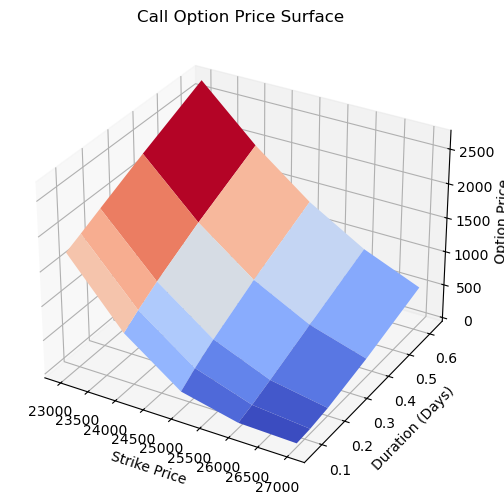

In [9]:
import matplotlib.pyplot as plt
strike_prices = np.unique(np.array([k[0] for k in CE_prices_dict.keys()]))
durations = np.unique(np.array([k[1] for k in CE_prices_dict.keys()]))
prices = np.array([v for v in CE_prices_dict.values()])

Strike, Duration = np.meshgrid(strike_prices, durations)

# Fill the price grid
Price = np.zeros_like(Strike, dtype=float)
for i, dur in enumerate(durations):
    for j, strike in enumerate(strike_prices):
        Price[i, j] = CE_prices_dict[(strike, dur)]

# Plotting
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(Strike, Duration, Price, cmap='coolwarm')

ax.set_xlabel('Strike Price')
ax.set_ylabel('Duration (Days)')
ax.set_zlabel('Option Price')
ax.set_title('Call Option Price Surface')

plt.show()

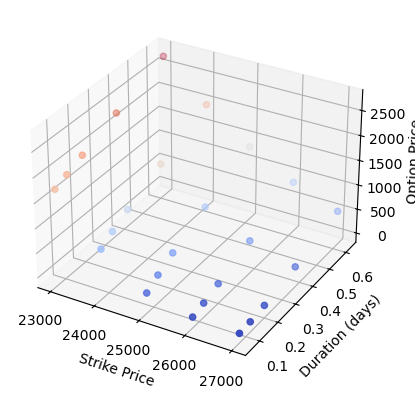

In [10]:
from mpl_toolkits.mplot3d import Axes3D

X = np.array([k[0] for k in CE_prices_dict.keys()])
Y = np.array([k[1] for k in CE_prices_dict.keys()])
Z = np.array(list(CE_prices_dict.values()))

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X, Y, Z, c=Z, cmap='coolwarm')  # scatter plot
ax.set_xlabel('Strike Price')
ax.set_ylabel('Duration (days)')
ax.set_zlabel('Option Price')

plt.show()

In [11]:
df = pd.read_csv('Option-Chain.csv')
df = df.iloc[:, [0, 9, 11]]

df['EXPIRY DATE'] = pd.to_datetime(df['EXPIRY DATE'])
df = df.sort_values(by=["PRICE","EXPIRY DATE"])
df['EXPIRY DATE'] = df['EXPIRY DATE'].apply(lambda x: x.strftime('%d-%b-%Y'))

print(df)

      PRICE       ASK  EXPIRY DATE
16  23000.0  1,633.25  14-Aug-2025
17  23000.0  1,655.60  21-Aug-2025
18  23000.0  1,680.00  28-Aug-2025
19  23000.0         -  02-Sep-2025
20  23000.0         -  09-Sep-2025
..      ...       ...          ...
71  27000.0         -  28-Dec-2027
72  27000.0         -  27-Jun-2028
73  27000.0         -  26-Dec-2028
74  27000.0         -  24-Dec-2029
75  27000.0         -  25-Jun-2030

[76 rows x 3 columns]


/var/folders/zp/_z5ytlrj39x9_lyt_g51rrfm0000gn/T/ipykernel_55841/3351704563.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['EXPIRY DATE'] = pd.to_datetime(df['EXPIRY DATE'])


In [12]:
other = pd.DataFrame(
    [(k[0], k[1], v) for k, v in CE_prices_dict.items()],
    columns=["PRICE", "DURATION", "OPTION PRICE"]
)

other['EXPIRY DATE'] = other['DURATION'].apply(
    lambda x: (datetime.today() + timedelta(days=int(x*365)+1)).date()
)
other = other.sort_values(by=["PRICE","EXPIRY DATE"])
other = other.iloc[:,[0,2,3]]

target_date = datetime.strptime('08-Sep-2025', '%d-%b-%Y').date()
other.loc[other['EXPIRY DATE'] == target_date, 'EXPIRY DATE'] = other.loc[other['EXPIRY DATE'] == target_date, 'EXPIRY DATE'] + pd.DateOffset(days=1)

other['EXPIRY DATE'] = other['EXPIRY DATE'].apply(lambda x: x.strftime('%d-%b-%Y'))
print(other)

    PRICE  OPTION PRICE  EXPIRY DATE
0   23000       1732.20  09-Sep-2025
5   23000       1833.91  30-Sep-2025
10  23000       1975.80  28-Oct-2025
15  23000       2288.52  30-Dec-2025
20  23000       2711.18  31-Mar-2026
1   24000        813.92  09-Sep-2025
6   24000        969.15  30-Sep-2025
11  24000       1151.62  28-Oct-2025
16  24000       1508.15  30-Dec-2025
21  24000       1957.87  31-Mar-2026
2   25000        216.06  09-Sep-2025
7   25000        371.99  30-Sep-2025
12  25000        550.40  28-Oct-2025
17  25000        896.19  30-Dec-2025
22  25000       1333.54  31-Mar-2026
3   26000         25.58  09-Sep-2025
8   26000         95.42  30-Sep-2025
13  26000        208.15  28-Oct-2025
18  26000        474.90  30-Dec-2025
23  26000        853.39  31-Mar-2026
4   27000          1.22  09-Sep-2025
9   27000         15.71  30-Sep-2025
14  27000         61.19  28-Oct-2025
19  27000        223.18  30-Dec-2025
24  27000        512.21  31-Mar-2026


In [13]:
merged_df = pd.merge(df, other, on=['EXPIRY DATE', 'PRICE'], how='inner')
print(merged_df)

      PRICE       ASK  EXPIRY DATE  OPTION PRICE
0   23000.0         -  09-Sep-2025       1732.20
1   23000.0  1,838.95  30-Sep-2025       1833.91
2   23000.0  2,002.80  28-Oct-2025       1975.80
3   23000.0  2,299.00  30-Dec-2025       2288.52
4   23000.0         -  31-Mar-2026       2711.18
5   24000.0  1,143.50  09-Sep-2025        813.92
6   24000.0       947  30-Sep-2025        969.15
7   24000.0  1,124.95  28-Oct-2025       1151.62
8   24000.0  1,479.40  30-Dec-2025       1508.15
9   24000.0  1,941.40  31-Mar-2026       1957.87
10  25000.0    164.45  09-Sep-2025        216.06
11  25000.0     301.8  30-Sep-2025        371.99
12  25000.0     471.3  28-Oct-2025        550.40
13  25000.0     819.9  30-Dec-2025        896.19
14  25000.0  1,292.15  31-Mar-2026       1333.54
15  26000.0        16  09-Sep-2025         25.58
16  26000.0      52.4  30-Sep-2025         95.42
17  26000.0     128.6  28-Oct-2025        208.15
18  26000.0    377.25  30-Dec-2025        474.90
19  26000.0    746.8

In [14]:
new_row = {
    'PRICE': 27000,
    'ASK': np.nan,   # Use NaN for missing value
    'EXPIRY DATE': '09-Sep-2025',
    'OPTION PRICE': 7.20
}

# Add the new row
merged_df = pd.concat([merged_df, pd.DataFrame([new_row])], ignore_index=True)

In [15]:
new_row = {
    'PRICE': 27000,
    'ASK': np.nan,   # Use NaN for missing value
    'EXPIRY DATE': '28-Oct-2025',
    'OPTION PRICE': 48.14
}

# Add the new row
merged_df = pd.concat([merged_df, pd.DataFrame([new_row])], ignore_index=True)
print(merged_df)

      PRICE       ASK  EXPIRY DATE  OPTION PRICE
0   23000.0         -  09-Sep-2025       1732.20
1   23000.0  1,838.95  30-Sep-2025       1833.91
2   23000.0  2,002.80  28-Oct-2025       1975.80
3   23000.0  2,299.00  30-Dec-2025       2288.52
4   23000.0         -  31-Mar-2026       2711.18
5   24000.0  1,143.50  09-Sep-2025        813.92
6   24000.0       947  30-Sep-2025        969.15
7   24000.0  1,124.95  28-Oct-2025       1151.62
8   24000.0  1,479.40  30-Dec-2025       1508.15
9   24000.0  1,941.40  31-Mar-2026       1957.87
10  25000.0    164.45  09-Sep-2025        216.06
11  25000.0     301.8  30-Sep-2025        371.99
12  25000.0     471.3  28-Oct-2025        550.40
13  25000.0     819.9  30-Dec-2025        896.19
14  25000.0  1,292.15  31-Mar-2026       1333.54
15  26000.0        16  09-Sep-2025         25.58
16  26000.0      52.4  30-Sep-2025         95.42
17  26000.0     128.6  28-Oct-2025        208.15
18  26000.0    377.25  30-Dec-2025        474.90
19  26000.0    746.8

In [16]:
merged_df['ASK'] = merged_df['ASK'].replace('-', np.nan)

print(merged_df)

      PRICE       ASK  EXPIRY DATE  OPTION PRICE
0   23000.0       NaN  09-Sep-2025       1732.20
1   23000.0  1,838.95  30-Sep-2025       1833.91
2   23000.0  2,002.80  28-Oct-2025       1975.80
3   23000.0  2,299.00  30-Dec-2025       2288.52
4   23000.0       NaN  31-Mar-2026       2711.18
5   24000.0  1,143.50  09-Sep-2025        813.92
6   24000.0       947  30-Sep-2025        969.15
7   24000.0  1,124.95  28-Oct-2025       1151.62
8   24000.0  1,479.40  30-Dec-2025       1508.15
9   24000.0  1,941.40  31-Mar-2026       1957.87
10  25000.0    164.45  09-Sep-2025        216.06
11  25000.0     301.8  30-Sep-2025        371.99
12  25000.0     471.3  28-Oct-2025        550.40
13  25000.0     819.9  30-Dec-2025        896.19
14  25000.0  1,292.15  31-Mar-2026       1333.54
15  26000.0        16  09-Sep-2025         25.58
16  26000.0      52.4  30-Sep-2025         95.42
17  26000.0     128.6  28-Oct-2025        208.15
18  26000.0    377.25  30-Dec-2025        474.90
19  26000.0    746.8

In [17]:
merged_df = merged_df.dropna()
print(merged_df)

      PRICE       ASK  EXPIRY DATE  OPTION PRICE
1   23000.0  1,838.95  30-Sep-2025       1833.91
2   23000.0  2,002.80  28-Oct-2025       1975.80
3   23000.0  2,299.00  30-Dec-2025       2288.52
5   24000.0  1,143.50  09-Sep-2025        813.92
6   24000.0       947  30-Sep-2025        969.15
7   24000.0  1,124.95  28-Oct-2025       1151.62
8   24000.0  1,479.40  30-Dec-2025       1508.15
9   24000.0  1,941.40  31-Mar-2026       1957.87
10  25000.0    164.45  09-Sep-2025        216.06
11  25000.0     301.8  30-Sep-2025        371.99
12  25000.0     471.3  28-Oct-2025        550.40
13  25000.0     819.9  30-Dec-2025        896.19
14  25000.0  1,292.15  31-Mar-2026       1333.54
15  26000.0        16  09-Sep-2025         25.58
16  26000.0      52.4  30-Sep-2025         95.42
17  26000.0     128.6  28-Oct-2025        208.15
18  26000.0    377.25  30-Dec-2025        474.90
19  26000.0    746.85  31-Mar-2026        853.39
20  27000.0      12.6  30-Sep-2025         15.71
21  27000.0     147.

In [18]:
# Replace commas in the string values before converting to float
#merged_df['OPTION PRICE'] = merged_df['OPTION PRICE'].str.replace(',', '')
merged_df['ASK'] = merged_df['ASK'].str.replace(',', '')

# Now convert to float and calculate the absolute error
merged_df['ABSOLUTE ERROR'] = abs(merged_df['OPTION PRICE'].astype(float) - merged_df['ASK'].astype(float))
print(merged_df)

      PRICE      ASK  EXPIRY DATE  OPTION PRICE  ABSOLUTE ERROR
1   23000.0  1838.95  30-Sep-2025       1833.91            5.04
2   23000.0  2002.80  28-Oct-2025       1975.80           27.00
3   23000.0  2299.00  30-Dec-2025       2288.52           10.48
5   24000.0  1143.50  09-Sep-2025        813.92          329.58
6   24000.0      947  30-Sep-2025        969.15           22.15
7   24000.0  1124.95  28-Oct-2025       1151.62           26.67
8   24000.0  1479.40  30-Dec-2025       1508.15           28.75
9   24000.0  1941.40  31-Mar-2026       1957.87           16.47
10  25000.0   164.45  09-Sep-2025        216.06           51.61
11  25000.0    301.8  30-Sep-2025        371.99           70.19
12  25000.0    471.3  28-Oct-2025        550.40           79.10
13  25000.0    819.9  30-Dec-2025        896.19           76.29
14  25000.0  1292.15  31-Mar-2026       1333.54           41.39
15  26000.0       16  09-Sep-2025         25.58            9.58
16  26000.0     52.4  30-Sep-2025       

In [19]:
merged_df['RELATIVE ERROR'] = merged_df['ABSOLUTE ERROR'] / merged_df['ASK'].astype(float)
print(merged_df)

      PRICE      ASK  EXPIRY DATE  OPTION PRICE  ABSOLUTE ERROR  \
1   23000.0  1838.95  30-Sep-2025       1833.91            5.04   
2   23000.0  2002.80  28-Oct-2025       1975.80           27.00   
3   23000.0  2299.00  30-Dec-2025       2288.52           10.48   
5   24000.0  1143.50  09-Sep-2025        813.92          329.58   
6   24000.0      947  30-Sep-2025        969.15           22.15   
7   24000.0  1124.95  28-Oct-2025       1151.62           26.67   
8   24000.0  1479.40  30-Dec-2025       1508.15           28.75   
9   24000.0  1941.40  31-Mar-2026       1957.87           16.47   
10  25000.0   164.45  09-Sep-2025        216.06           51.61   
11  25000.0    301.8  30-Sep-2025        371.99           70.19   
12  25000.0    471.3  28-Oct-2025        550.40           79.10   
13  25000.0    819.9  30-Dec-2025        896.19           76.29   
14  25000.0  1292.15  31-Mar-2026       1333.54           41.39   
15  26000.0       16  09-Sep-2025         25.58            9.5

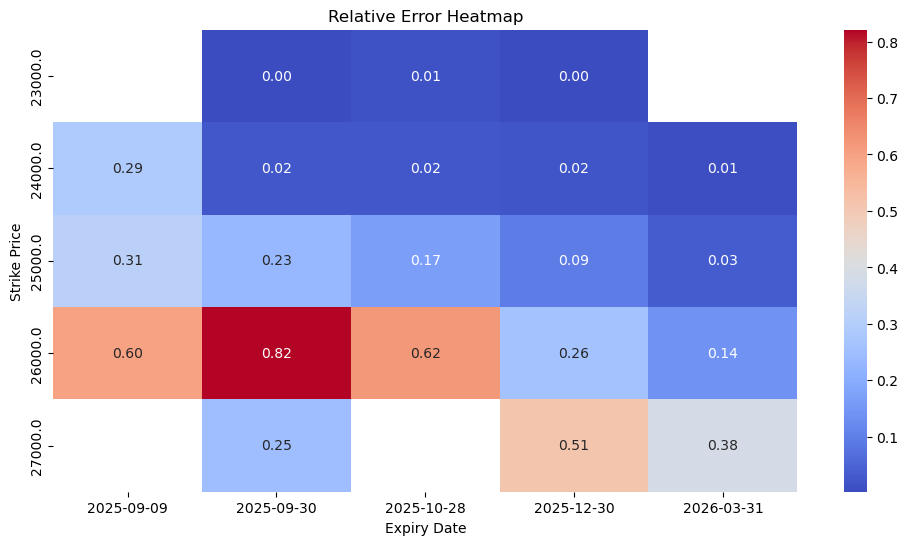

In [63]:
import seaborn as sns

# Convert 'EXPIRY DATE' to datetime if it's not already
merged_df['EXPIRY DATE'] = pd.to_datetime(merged_df['EXPIRY DATE'], format='%d-%b-%Y').dt.date

# Create a pivot table: PRICE as rows, EXPIRY DATE as columns, value = RELATIVE ERROR
pivot_table = merged_df.pivot(index='PRICE', columns='EXPIRY DATE', values='RELATIVE ERROR')

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Relative Error Heatmap")
plt.ylabel("Strike Price")
plt.xlabel("Expiry Date")
plt.show()